# Importing libraries


In [6]:
import graspologic
# set the environment path to find Recommenders
%load_ext autoreload
%autoreload 2
import random
import sys
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType, LongType, StructType, StructField
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.feature import HashingTF, CountVectorizer, VectorAssembler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
import json
import seaborn as sns
import pyspark
import torch
from tqdm import tqdm 
import fastai
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages
import surprise
import networkx as nx
from recommenders.utils.general_utils import get_number_processors
from recommenders.utils.gpu_utils import get_cuda_version, get_cudnn_version
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split

from benchmark_utils import *
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkDiversityEvaluation
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.evaluation.python_evaluation import catalog_coverage, novelty, distributional_coverage, diversity, serendipity

from pyspark.sql.window import Window
import pyspark.sql.functions as F
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("System version: {}".format(sys.version))
print("Spark version: {}".format(pyspark.__version__))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))
print("Surprise version: {}".format(surprise.__version__))
print("PyTorch version: {}".format(torch.__version__))
print("Fast AI version: {}".format(fastai.__version__))
print("Cornac version: {}".format(cornac.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("CUDA version: {}".format(get_cuda_version()))
print("CuDNN version: {}".format(get_cudnn_version()))
n_cores = get_number_processors()
print("Number of cores: {}".format(n_cores))
from graspologic.simulations import mmsbm, sbm
from graspologic.plot import heatmap
from scipy.stats import poisson

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System version: 3.9.12 (main, Mar 26 2022, 15:51:15) 
[Clang 13.1.6 (clang-1316.0.21.2)]
Spark version: 3.2.1
Pandas version: 1.4.2
PySpark version: 3.2.1
Surprise version: 1.1.1
PyTorch version: 1.11.0
Fast AI version: 2.5.6
Cornac version: 1.14.2
Tensorflow version: 2.8.0
CUDA version: No CUDA in this machine
CuDNN version: No CUDNN in this machine
Number of cores: 12


# Generating Synthetic Data and Movie Lens Data

In this section we will build synthetic data for testing our recommendation algorithms.

The main idea is to artificially build different group of individual and define probability of being drawn by certain item over others. We suppose for now that we have two groups: group A and group B. Members of group A and group B are interested in specific activities with a specific probability that we preliminary define. For example, a member of group A can be into racing cars with a probability of $p^A_\text{car}$ while a member of group B has a smaller probability equal to $p^B_\text{car}$. We suppose that we have up to $K$ type of items and $M$ different groups of identical population and we generate a stochastic block modelling to generate the different group. When we identify that a user is drawn to a specific item, we draw a Poisson distribution of parameters equal to 4. On the other hand, if the user has no interest, we draw a Poisson distribution of parameters equal to 2. At the end of the process, we obtain an artificial rating matrix that captures different interest present in the population 

In [ ]:

# Building data according to a certain distribution of iteration data. N

rng = np.random.default_rng(123)
number_of_categories = 5
n_of_categories = 50
n_of_items = 100
number_of_items = 4
n = [n_of_categories] * number_of_categories
n.extend([n_of_items]*number_of_items)
print(len(n))
# p = np.array([[0, 0, 0, 0, 0.8, 0.2, 0.2],
#               [0, 0, 0, 0, 0.8, 0.8, 0.2],
#               [0, 0, 0, 0, 0.2, 0.8, 0.8],
#               [0, 0, 0, 0, 0.2, 0.2, 0.8],
#               [0.8, 0.8, 0.2, 0.2, 0, 0, 0],
#               [0, 0.8, 0.8, 0, 0, 0, 0],
#               [0.2, 0.2, 0.8, 0.8, 0, 0, 0]])
# p = 
p = np.array([[0.5,0.3,0.8,0.2],
             [0.2, 0.5,0.8,0.3],
             [0.1, 0.1,0.9,0.4],
             [0.4, 0.4,0.4,0.8],
             [0.2, 0.5,0.1,0.7],
             ])

list_of_array = np.zeros((number_of_categories+number_of_items,number_of_categories+number_of_items))
for i in range(number_of_categories,number_of_categories+number_of_items):
    for j in range(0,number_of_categories):
        list_of_array[i][j] = p[j][i-number_of_categories]
        list_of_array[j][i] = p[j][i-number_of_categories]
G_sbm = sbm(n, list_of_array, directed=False, loops=False)
heatmap(G_sbm, cbar=False, title='SBM Simulation for 5 group of individuals and 4 categories of items');
plt.savefig('Outputs/SBM_5c_n3.png')
# from numpy.random import normal, poisson

dict_user = {}
dict_items = {}
rating = []
for i in range(number_of_categories*n_of_categories,G_sbm.shape[0]):
    for j in range(0,number_of_categories*n_of_categories):
        dict_user['u'+str(i-number_of_categories*n_of_categories)] = int((i-number_of_categories*n_of_categories)/n_of_items)
        dict_items['i' + str(j)] = int(j/n_of_categories)
        if G_sbm[i][j] == 0:
            val = poisson.rvs(mu=3, size=1)
            rating.append([i-number_of_categories*n_of_categories,j,val[0]/2.0, int((i-number_of_categories*n_of_categories)/n_of_items),int(j/n_of_categories)])
        else:
            val = poisson.rvs(mu=8, size=1)
            rating.append([i-number_of_categories*n_of_categories,j,val[0]/2.0, int((i-number_of_categories*n_of_categories)/n_of_items),int(j/n_of_categories)])
df_with_poisson = pd.DataFrame(rating,columns = ['itemID','userID','rating','group','category'])
putting_age_into_bins = range(10,80,5)
random_sample = list(np.random.normal(35, 10, df_with_poisson.shape[0]))
ages = []
for val in random_sample:
    age = min(putting_age_into_bins, key=lambda x:abs(x-val))
    ages.append(age)
df_with_poisson['age'] = ages
df_with_poisson,dict_user

In [3]:
from scipy.stats import zipf
from collections import Counter
def creating_masked_entries(nrow,ncol,bias_representation,length_of_people,density,strategy):
    mask = []
    ks = []
    success = 0
    mask_index = []
    print(length_of_people)
    if strategy == 'skewed':
        bias_representation = [0.1,0.05,0.5,0.2,0.15]
        bias_representation_cum = np.cumsum(bias_representation, dtype=float)

        for i in tqdm(range(nrow)):
            rand_val = random.random()
            for j in range(ncol):
                k = 0 
                while bias_representation_cum[k] < random.random():
                    k +=1 
                    ks.append(k-1)
                if random.random() < bias_representation[k]*2*rand_val:
                    mask.append(1)
                    success +=1 
                    mask_index.append((i,j))
                else:
                    mask.append(0)
    elif strategy == 'balanced':
        bias_representation = [1/float(len(length_of_people))]*len(length_of_people)
        bias_representation_cum = np.cumsum(bias_representation, dtype=float)
        ks = []
        success = 0
        mask_index = []
        shuffled_col = list(range(ncol))
        random.shuffle(shuffled_col)
        for i in tqdm(range(nrow)):
            for j in range(ncol):
                rand_val = random.random() 
                k = 0 
                while bias_representation_cum[k] < rand_val:
                    k +=1 
                    ks.append(k-1)
                if random.random() < density:
#                     j_sample = (0,col)
                    j_sample = shuffled_col[min(zipf.rvs(a=1.5),ncol-1)]
                    i_sample = random.randint(k*length_of_people[k],(k+1)*length_of_people[k])
                    while (i_sample, j_sample) in mask_index:
                        j_sample += 1 
                    mask_index.append((i_sample,j_sample))
    return mask_index
#     for i in range(nrow):
#         for j in range(ncol):
            
#     mask = []
#     distributions = []
#     for i in range(nrow):
#         for j in range(ncol):
#             distributions.append(i * ncol)
#     for i in tqdm(range(nrow)):
#         for j in range(ncol):
#             threshold_discarding = distributions[i * nrow + j] / float(nrow * ncol)
#             if random.random() > threshold_discarding:
#                 mask.append(1)
#             else:
#                 mask.append(0)
#     mask = np.array(mask)
#     mask = mask.reshape((nrow, ncol))
#     return mask



# masked = creating_masked_entries(number_of_categories*n_of_categories,n_of_users*number_of_items,[0.1,0.05,0.5,0.2,0.15],n)
masked = creating_masked_entries(df_with_poisson['userID'].nunique(),df_with_poisson['itemID'].nunique(),[0.1,0.05,0.5,0.2,0.15],n,density=0.1,strategy='balanced')
n

[50, 50, 50, 50, 50, 100, 100, 100, 100]


100%|██████████| 250/250 [00:07<00:00, 32.74it/s]


[50, 50, 50, 50, 50, 100, 100, 100, 100]

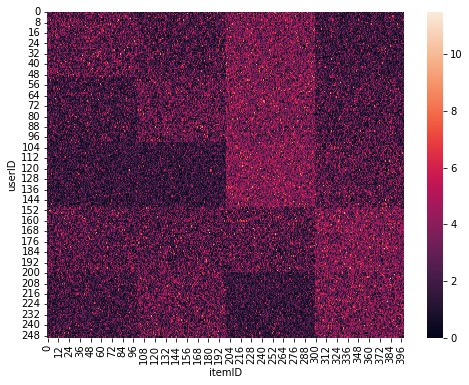

In [4]:
# sns.heatmap(df_with_poisson)
df_squared = df_with_poisson.pivot(index='userID', columns='itemID', values='rating').fillna(0)
# df_squared = df_squared.sample(frac = 1)
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.heatmap(df_squared)
plt.savefig('Outputs/matrix_generation.png')

In [5]:
# df_with_poisson.head()
restricted_df = []
for (i,j) in tqdm(masked):
#         if masked[i,j] == 1:
#             df_with_poisson[df_with_poisson['UserID']==i&&df_with_poisson['MovieID']==j]
    restricted_df.append(df_with_poisson[(df_with_poisson['userID']==i)&(df_with_poisson['itemID']==j)])

#         df_with_poisson[df_with_poisson['UserID']==i&df_with_poisson['MovieID']==i]
restricted_df = pd.concat(restricted_df)


100%|██████████| 9989/9989 [00:16<00:00, 601.02it/s]


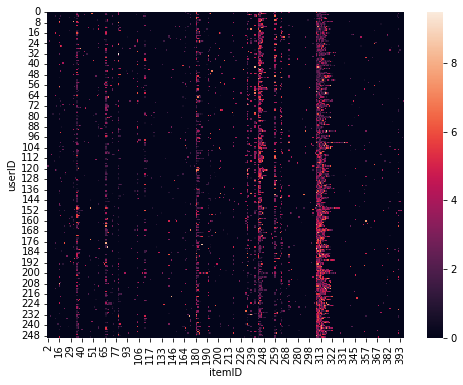

In [6]:
df_squared = restricted_df.pivot(index='userID', columns='itemID', values='rating').fillna(0)
# df_squared = df_squared.sample(frac = 1)
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.heatmap(df_squared)
plt.savefig('Outputs/matrix_generation_after_masking.png')

## Investigating statistics of our synthetic datasets

Text(0.5, 1.0, 'Movie Rating Distribution')

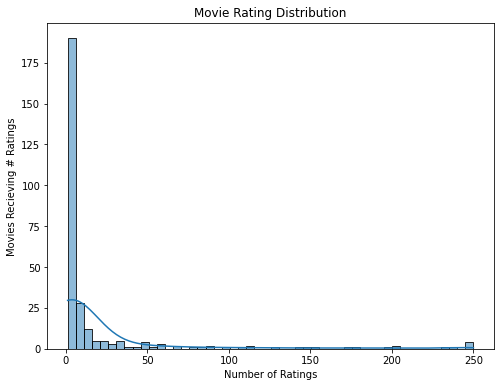

In [8]:
ratings_synthetic_mean_count = pd.DataFrame(restricted_df.groupby('itemID')['rating'].mean())
ratings_synthetic_mean_count['Rating_Counts'] = pd.DataFrame(restricted_df.groupby('itemID')['rating'].count())

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.histplot(data=ratings_synthetic_mean_count, x="Rating_Counts", kde=True, bins = 50)
plt.xlabel('Number of Ratings')
plt.ylabel('Movies Recieving # Ratings')
plt.title('Movie Rating Distribution')

<AxesSubplot:xlabel='age', ylabel='Count'>

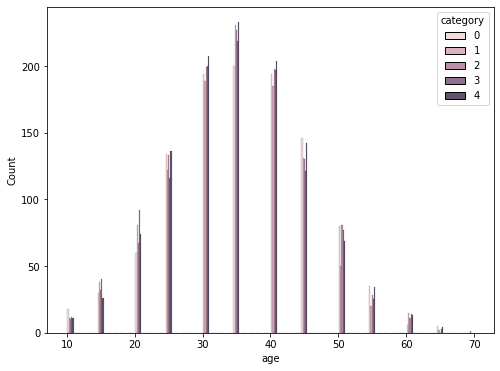

In [10]:
# df_with_poisson.groupby(['Category']).nunique()
plt.figure(figsize=(8,6))
sns.histplot(data = restricted_df, x = restricted_df['age'], hue = restricted_df['category'],multiple="dodge", shrink=.8)

<Figure size 576x432 with 0 Axes>

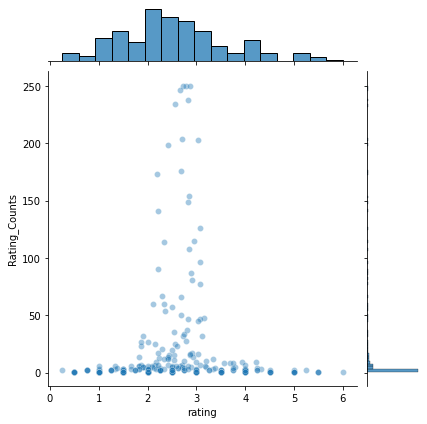

In [11]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='Rating_Counts', data=ratings_synthetic_mean_count, alpha=0.4)

<Figure size 576x432 with 0 Axes>

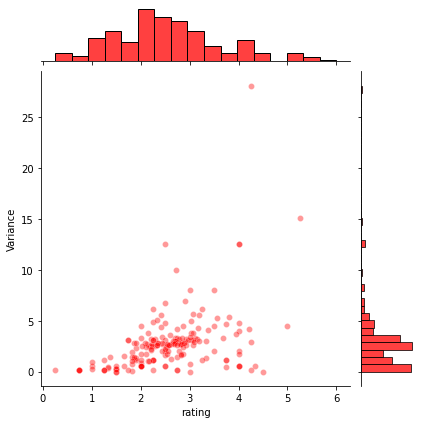

In [13]:
ratings_synthetic_mean_count['Variance'] = pd.DataFrame(restricted_df.groupby('itemID')['rating'].var())

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='Variance', data=ratings_synthetic_mean_count, alpha=0.4,color='r')

## Comparing the Properties with MovieLens Data 1M

In [32]:
path_to_data = "Data/ML1M/"
movies_df = pd.read_csv(path_to_data +
    'movies.dat',
    sep='::',
    names=['itemID','Title','Genres'],
    engine='python',
    encoding='latin-1',
    header=None
)
users_df = pd.read_csv(path_to_data +
    'users.dat',
    sep='::',
    names=['userID','Gender','Age', 'Occupation', 'zip-code'],
    engine='python',
    encoding='latin-1',
    header=None
)
ratings_df = pd.read_csv(path_to_data +
    'ratings.dat',
    sep='::',
    names=['userID','itemID','Rating', 'Timestamp'],
    parse_dates=['Timestamp'],
    engine='python',
    encoding='latin-1',
    header=None
)

In [15]:
def clean_movie_title(movie_title):
    if movie_title.split(" ")[-1].startswith("("):
        # remove year from the title, e.g. Toy Story (1995) --> Toy Story
        movie_title = (" ".join(movie_title.split(" ")[:-1])).strip()

    if movie_title.title().split(',')[-1].strip() in ['The', 'A']:
        # article + movie title, e.g. Saint, The --> The Saint
        movie_title = (movie_title.title().split(',')[-1].strip() + " " + " ".join(movie_title.title().split(',')[:-1])).strip()

    # otherwise, it was converting The Devil's Advocate to The Devil'S Advocate
    movie_title = movie_title.lower()
    return movie_title

column_item = ["movie_id_ml", "title", "release", "vrelease", "url", "unknown", 
                    "action", "adventure", "animation", "childrens", "comedy",
                   "crime", "documentary", "drama", "fantasy", "noir", "horror",
                   "musical", "mystery", "romance", "scifi", "thriller",
                   "war", "western"]

df_ML_movies = pd.read_csv('Data/ml-100k/u.item', delimiter='|', names=column_item, encoding = "ISO-8859-1") 
df_ML_movies = df_ML_movies.drop(columns=["vrelease"])
df_ML_movies["title"] = df_ML_movies["title"].apply(lambda row : clean_movie_title(row))   
df_ML_movies["release"] = df_ML_movies["release"].apply(lambda x : str(x).split("-")[-1])

# drop rows where movie starts with brackets, those are some strange names...
df_ML_movies = df_ML_movies[~df_ML_movies.title.str.startswith("(")]

# handle seven (se7en) movies, creating new rows containing the content of brackets
_df = df_ML_movies[df_ML_movies.title.str.contains("(", regex=False)]
# _df.title = _df.title.apply(lambda x: re.search(r'\((.*?)\)', x).group(1).strip() if re.search(r'\((.*?)\)', x) else x.strip())
df_ML_movies = df_ML_movies.append(_df)

print(df_ML_movies.shape)
print(df_ML_movies.dtypes)
df_ML_movies.head()

(1767, 23)
movie_id_ml     int64
title          object
release        object
url            object
unknown         int64
action          int64
adventure       int64
animation       int64
childrens       int64
comedy          int64
crime           int64
documentary     int64
drama           int64
fantasy         int64
noir            int64
horror          int64
musical         int64
mystery         int64
romance         int64
scifi           int64
thriller        int64
war             int64
western         int64
dtype: object


,movie_id_ml,title,release,url,unknown,action,adventure,animation,childrens,comedy,...,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,toy story,1995,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,goldeneye,1995,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,four rooms,1995,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,get shorty,1995,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,copycat,1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
movie_ratings_df = pd.merge(movies_df, ratings_df, on='itemID')
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   itemID     1000209 non-null  int64 
 1   Title      1000209 non-null  object
 2   Genres     1000209 non-null  object
 3   userID     1000209 non-null  int64 
 4   Rating     1000209 non-null  int64 
 5   Timestamp  1000209 non-null  object
dtypes: int64(3), object(3)
memory usage: 53.4+ MB


In [17]:
movie_ratings_users_df = pd.merge(
    movie_ratings_df,
    users_df,
    on='userID'
)
Master_Data = movie_ratings_users_df.drop(
    ['zip-code', 'Timestamp'],
    axis=1
)
Master_Data.describe(include='all')


,itemID,Title,Genres,userID,Rating,Gender,Age,Occupation
count,1.000209e+06,1000209,1000209,1.000209e+06,1.000209e+06,1000209,1.000209e+06,1.000209e+06
unique,NaN,3706,301,NaN,NaN,2,NaN,NaN
top,NaN,American Beauty (1999),Comedy,NaN,NaN,M,NaN,NaN
freq,NaN,3428,116883,NaN,NaN,753769,NaN,NaN
mean,1.865540e+03,NaN,NaN,3.024512e+03,3.581564e+00,NaN,2.973831e+01,8.036138e+00
std,1.096041e+03,NaN,NaN,1.728413e+03,1.117102e+00,NaN,1.175198e+01,6.531336e+00
min,1.000000e+00,NaN,NaN,1.000000e+00,1.000000e+00,NaN,1.000000e+00,0.000000e+00
25%,1.030000e+03,NaN,NaN,1.506000e+03,3.000000e+00,NaN,2.500000e+01,2.000000e+00
50%,1.835000e+03,NaN,NaN,3.070000e+03,4.000000e+00,NaN,2.500000e+01,7.000000e+00
75%,2.770000e+03,NaN,NaN,4.476000e+03,4.000000e+00,NaN,3.500000e+01,1.400000e+01


<AxesSubplot:xlabel='Age', ylabel='Count'>

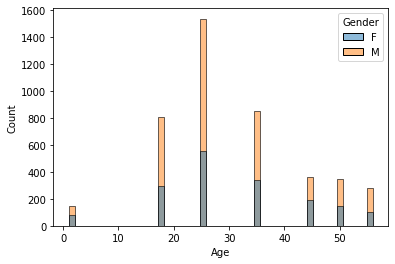

In [18]:
sns.histplot(data = users_df, x = users_df['Age'], hue = users_df['Gender'])

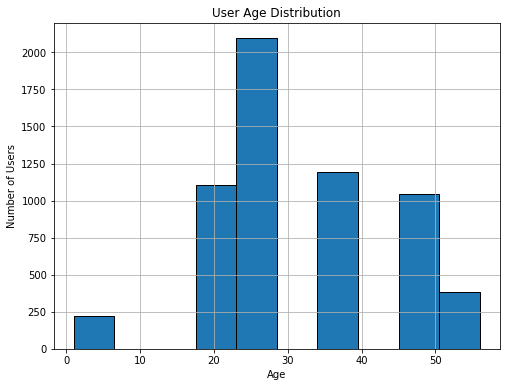

In [19]:
plt.figure(figsize=(8,6))
users_df.Age.hist()
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

Text(0.5, 1.0, 'Movie Rating Distribution')

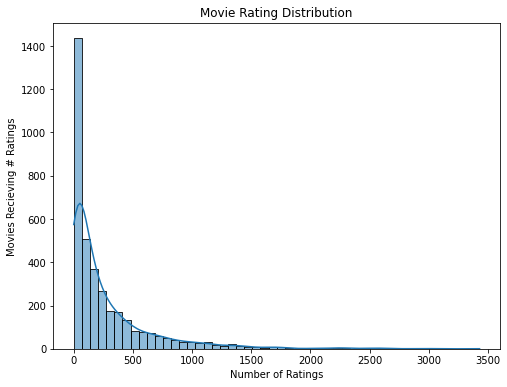

In [20]:
ratings_mean_count = pd.DataFrame(Master_Data.groupby('Title')['Rating'].mean())
ratings_mean_count['Rating_Counts'] = pd.DataFrame(Master_Data.groupby('Title')['Rating'].count())

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.histplot(data=ratings_mean_count, x="Rating_Counts", kde=True, bins = 50)
plt.xlabel('Number of Ratings')
plt.ylabel('Movies Recieving # Ratings')
plt.title('Movie Rating Distribution')

<Figure size 576x432 with 0 Axes>

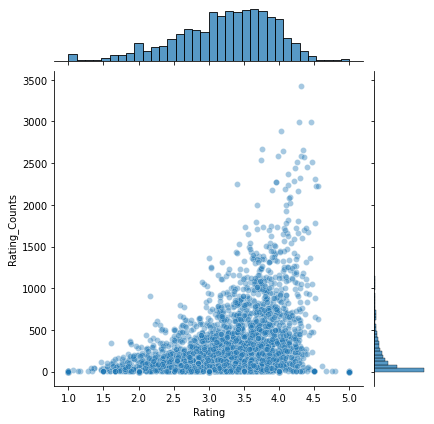

In [21]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='Rating_Counts', data=ratings_mean_count, alpha=0.4)

<Figure size 576x432 with 0 Axes>

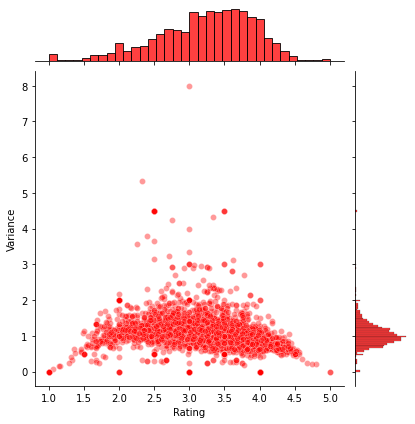

In [22]:
ratings_mean_count['Variance'] = pd.DataFrame(Master_Data.groupby('Title')['Rating'].var())

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='Variance', data=ratings_mean_count, alpha=0.4,color='r')

<Figure size 576x432 with 0 Axes>

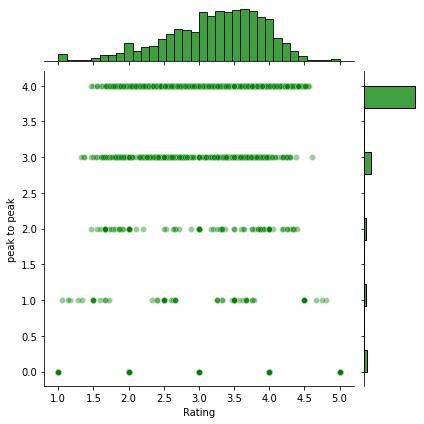

In [23]:
ratings_mean_count['peak to peak'] = pd.DataFrame(Master_Data.groupby('Title')['Rating'].agg(np.ptp))
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='peak to peak', data=ratings_mean_count, alpha=0.4,color='green')

Augmenting with meta-information from IMDB

In [24]:
columns_movies = ["movie_id", "title", "imdb_idx",
                  "movie_kind", "release", "imdb_id", "phonetic", "episode_id",
                  "season", "episode", "series_years", "md5"]

df_IMDb_movies = pd.read_csv('Data/tmdb_5000_movies.csv', delimiter=',',encoding = "ISO-8859-1", low_memory=False) 
# df_IMDb_movies = df_IMDb_movies.drop(columns=["imdb_idx", "imdb_id", "phonetic", "md5", "episode_id", "episode", "movie_kind", "season", "series_years"])
# df_IMDb_movies = df_IMDb_movies.dropna(subset=['release'])
# print(df_IMDb_movies)
# df_IMDb_movies["release"] = df_IMDb_movies["release"].apply(lambda x : str(int(x)).split("-")[-1])
# # we lowered in MovieLens as well
df_IMDb_movies = df_IMDb_movies.dropna(subset=["original_title"])
df_IMDb_movies["title"] = df_IMDb_movies["original_title"].apply(lambda x: x.lower())

# # drop rows where movie starts with brackets, those are some strange names...
df_IMDb_movies = df_IMDb_movies[~df_IMDb_movies.title.str.startswith("(")]

# # handle seven (se7en) movies, creating new rows containing the content of brackets
_df = df_IMDb_movies[df_IMDb_movies.title.str.contains("(", regex=False)]
# _df.title = _df.title.apply(lambda x: re.search(r'\((.*?)\)', x).group(1).strip() if re.search(r'\((.*?)\)', x) else x.strip())
df_IMDb_movies = df_IMDb_movies.append(_df)

print(df_IMDb_movies.dtypes)
print(df_IMDb_movies.shape)
df_IMDb_movies.head()

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object
(4805, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""name"": ""alien planet""}, {""id"": 10987, ""name"": ""cgi""}, {""id"": 11399, ""name"": ""marine""}, {""id"": 13065, ""name"": ""soldier""}, {""id"": 14643, ""name"": ""battle""}, {""id"": 14720, ""name"": ""love affair""}, {""id"": 165...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id"": 574}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319, ""name"": ""east india trading company""}, {""id"": 2038, ""name"": ""love of one's life""}, {""id"": 2052, ""name"": ""traitor""}, {""id"": 2580, ""name"": ""shipwreck""}, {""id"": 2660, ""name"": ""strong woman""}, {""id"": 3799, ""name"": ""ship""}, {""id"": 5740, ""name"": ""alliance""}, {""id"": 5941, ""name"": ""calypso""}, {""id"": 6155, ""name"": ""afterlife""}, {""id"": 6211, ""name"": ""fighter""}, {""id"": 12988, ""name"": ""pirate""}, {""id"": 157186, ""name"": ""swashbuckler""}, {""id"": 179430, ""name"": ""aftercreditsstinger""}]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""name"": ""Second Mate Productions"", ""id"": 19936}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",pirates of the caribbean: at world's end,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret agent""}, {""id"": 9663, ""name"": ""sequel""}, {""id"": 14555, ""name"": ""mi6""}, {""id"": 156095, ""name"": ""british secret service""}, {""id"": 158431, ""name"": ""united kingdom""}]",en,Spectre,"A cryptic message from Bondâs past sends him on a trail to uncover a sinister organization. While M battles politic

# Recommender system
In this section, we build a couple of recommender systems and compare and contrast their performance for a wide-array of metric. This is intended to illustrate on how to automate the process of evaluating different recommender algorithms using tools from different repository. The algorithm builds on top of a benchmark_utils.py python script that centralizes a lot of the functionality needed and is inspired from a couple of notebooks that we have leveraged. We first spend some time to illustrate key concepts from recommender systems on a simple ALS example.




Set the default parameters.

In [19]:
# top k items to recommend
TOP_K = 25

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# user, item column names
COL_USER="userId"
COL_ITEM="itemId"
COL_RATING="Rating"
COL_TITLE="Title"
COL_GENRE="Genre"

### 1. Set up Spark context

The following settings work well for debugging locally on VM - change when running on a cluster. We set up a giant single executor with many threads and specify memory cap. 

In [14]:
# the following settings work well for debugging locally on VM - change when running on a cluster
# set up a giant single executor with many threads and specify memory cap

spark = start_or_get_spark("ALS PySpark", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")
spark.conf.set("spark.sql.crossJoin.enabled", "true")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/21 14:55:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### 2. Download the MovieLens dataset

In [20]:
# Note: The DataFrame-based API for ALS currently only supports integers for user and item ids.
schema = StructType(
    (
        StructField(DEFAULT_USER_COL, IntegerType()),
        StructField(DEFAULT_ITEM_COL, IntegerType()),
        StructField(DEFAULT_RATING_COL, FloatType()),
        StructField("Timestamp", LongType()),
    )
)

data = movielens.load_spark_df(spark, size=MOVIELENS_DATA_SIZE, schema=schema, title_col=COL_TITLE, genres_col=COL_GENRE)
data.show()

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-100k.zip
100%|██████████| 4.81k/4.81k [00:02<00:00, 1.96kKB/s]


+------+------+------+---------+--------------------+------+
|itemID|userID|rating|Timestamp|               Title| Genre|
+------+------+------+---------+--------------------+------+
|    26|   138|   5.0|879024232|Brothers McMullen...|Comedy|
|    26|   224|   3.0|888104153|Brothers McMullen...|Comedy|
|    26|    18|   4.0|880129731|Brothers McMullen...|Comedy|
|    26|   222|   3.0|878183043|Brothers McMullen...|Comedy|
|    26|    43|   5.0|883954901|Brothers McMullen...|Comedy|
|    26|   201|   4.0|884111927|Brothers McMullen...|Comedy|
|    26|   299|   4.0|878192601|Brothers McMullen...|Comedy|
|    26|    95|   3.0|880571951|Brothers McMullen...|Comedy|
|    26|    89|   3.0|879459909|Brothers McMullen...|Comedy|
|    26|   361|   3.0|879440941|Brothers McMullen...|Comedy|
|    26|   194|   3.0|879522240|Brothers McMullen...|Comedy|
|    26|   391|   5.0|877399745|Brothers McMullen...|Comedy|
|    26|   345|   3.0|884993555|Brothers McMullen...|Comedy|
|    26|   303|   4.0|87

#### Split the data using the Spark random splitter provided in utilities

In [21]:
train_df, test_df = spark_random_split(data.select(DEFAULT_USER_COL, DEFAULT_ITEM_COL, DEFAULT_RATING_COL), ratio=0.75, seed=123)
print ("N train_df", train_df.cache().count())
print ("N test_df", test_df.cache().count())

N train_df 75147


N test_df 24853


#### Get all possible user-item pairs

Note: We assume that training data contains all users and all catalog items. 

In [22]:
users = train_df.select(DEFAULT_USER_COL).distinct()
items = train_df.select(DEFAULT_ITEM_COL).distinct()
user_item = users.crossJoin(items)
user_item.show()

+------+------+
|userID|itemID|
+------+------+
|   148|    26|
|   148|   474|
|   148|  1677|
|   148|    29|
|   148|   964|
|   148|    65|
|   148|   191|
|   148|  1360|
|   148|  1010|
|   148|   418|
|   148|   558|
|   148|   541|
|   148|  1224|
|   148|  1258|
|   148|  1277|
|   148|  1127|
|   148|   222|
|   148|  1145|
|   148|  1551|
|   148|  1642|
+------+------+
only showing top 20 rows



### 3. Train ALS on the training data and get the top-k recommendations for our testing data

To predict movie ratings, we use the rating data in the training set as users' explicit feedback. The hyperparameters used in building the model are referenced from [here](http://mymedialite.net/examples/datasets.html). We do not constrain the latent factors (`nonnegative = False`) in order to allow for both positive and negative preferences towards movies.

#### We explictly build ALS to illustrate some key ideas and concepts

In [23]:
header = {
    "userCol": DEFAULT_USER_COL,
    "itemCol": DEFAULT_ITEM_COL,
    "ratingCol": DEFAULT_RATING_COL,
}


als = ALS(
    rank=10,
    maxIter=15,
    implicitPrefs=False,
    regParam=0.05,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=42,
    **header
)

In [24]:
with Timer() as train_time:
    model = als.fit(train_df)

print("Took {} seconds for training.".format(train_time.interval))

22/04/21 14:56:45 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/04/21 14:56:45 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/04/21 14:56:46 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Took 26.812570914000048 seconds for training.


Generate similar plots as the earlier one to understand performance of the suggestions

In [25]:
# Score all user-item pairs
dfs_pred = model.transform(user_item)

# Remove seen items.
dfs_pred_exclude_train = dfs_pred.alias("pred").join(
    train_df.alias("train"),
    (dfs_pred[DEFAULT_USER_COL] == train_df[DEFAULT_USER_COL]) & (dfs_pred[DEFAULT_ITEM_COL] == train_df[DEFAULT_ITEM_COL]),
    how='outer'
)

top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + DEFAULT_USER_COL, 'pred.' + DEFAULT_ITEM_COL, 'pred.' + "prediction")

print(top_all.count())

window = Window.partitionBy(DEFAULT_USER_COL).orderBy(F.col("prediction").desc())
top_k_reco = top_all.select("*", F.row_number().over(window).alias("rank")).filter(F.col("rank") <= TOP_K).drop("rank")

print(top_k_reco.count())


22/04/21 14:56:57 WARN Column: Constructing trivially true equals predicate, 'userID#6 = userID#6'. Perhaps you need to use aliases.


1464772


23575


In [26]:
users = train_df.select(als.getUserCol()).distinct().limit(3)

dfs_rec_subset = model.recommendForUserSubset(users, 10)
dfs_rec_subset.show(10)

+------+--------------------+
|userID|     recommendations|
+------+--------------------+
|   833|[{1368, 5.3286886...|
|   243|[{1176, 5.052174}...|
|   148|[{1142, 5.721592}...|
+------+--------------------+



In the movie recommendation use case, recommending movies that have been rated by the users does not make sense. Therefore, the rated movies are removed from the recommended items.

In order to achieve this, we recommend all movies to all users, and then remove the user-movie pairs that exist in the training dataset. 

Now that we have illustrated how we can build a simple recommender system for ALS, we can investigate a bunch of them.
We introduce a total of 9 recommender system (most of them are detailed more thoroughly in our report) (and a 10th is on the way).  

### Case Study 2

Case Study V1: 

1.   User 1: Gender (F), Age (25), Occupation (12) Programmer
2.   User 2: Gender (M), Age (25), Occupation (12) Programmer
3.   User 3: Gender (F), Age (25), Occupation (2) Artist

In [37]:
top_k_reco = top_k_reco.toPandas()

path_to_data = "Data/ML1M/"
movies_df = pd.read_csv(path_to_data +
    'movies.dat',
    sep='::',
    names=['itemID','Title','Genres'],
    engine='python',
    encoding='latin-1',
    header=None
)
users_df = pd.read_csv(path_to_data +
    'users.dat',
    sep='::',
    names=['userID','Gender','Age', 'Occupation', 'zip-code'],
    engine='python',
    encoding='latin-1',
    header=None
)
ratings_df = pd.read_csv(path_to_data +
    'ratings.dat',
    sep='::',
    names=['userID','itemID','Rating', 'Timestamp'],
    parse_dates=['Timestamp'],
    engine='python',
    encoding='latin-1',
    header=None
)
u1 = users_df.loc[(users_df['Gender'] == 'F')  & (users_df['Age'] == 25) & (users_df['Occupation'] == 12)]
u1_list = u1['userID'].tolist()
print(len(u1_list))

# get all top-k recommendations from users that match u1 profile
u1_recs = top_k_reco[top_k_reco['userID'].isin(u1_list)]
u1_recs


17


,userID,itemID,prediction
12625,648,1400,5.143148
12626,648,915,5.100910
12627,648,867,5.049032
12628,648,963,5.037336
12629,648,1167,4.956693
12630,648,733,4.888809
12631,648,1058,4.829468
12632,648,408,4.819495
12633,648,1166,4.812923
12634,648,172,4.769330


In [39]:
u2 = users_df.loc[(users_df['Gender'] == 'M')  & (users_df['Age'] == 25) & (users_df['Occupation'] == 12)]
u2_list = u2['userID'].tolist()
print(len(u2_list))

# get all top-k recommendations from users that match u2 profile
u2_recs = top_k_reco[top_k_reco['userID'].isin(u2_list)]
u2_recs

164


,userID,itemID,prediction
225,108,854,5.446690
226,108,1405,5.283926
227,108,611,5.279421
228,108,1463,5.165274
229,108,1084,5.138481
...,...,...,...
22895,722,1167,4.735322
22896,722,483,4.735064
22897,722,48,4.721562
22898,722,69,4.714643


In [40]:
u3 = users_df.loc[(users_df['Gender'] == 'F')  & (users_df['Age'] == 25) & (users_df['Occupation'] == 2)]
u3_list = u3['userID'].tolist()
print(len(u3_list))

# get all top-k recommendations from users that match u3 profile
u3_recs = top_k_reco[top_k_reco['userID'].isin(u3_list)]
u3_recs

31


,userID,itemID,prediction
9775,175,900,5.300072
9776,175,1463,5.207212
9777,175,315,5.045881
9778,175,969,5.022328
9779,175,705,5.018046
...,...,...,...
22170,475,1404,5.868865
22171,475,537,5.865817
22172,475,1149,5.859294
22173,475,1150,5.798280


In [41]:
# combine all user data
tmp = pd.concat([u1_recs, u2_recs, u3_recs], ignore_index=True)
tmp

,userID,itemID,prediction
0,648,1400,5.143148
1,648,915,5.100910
2,648,867,5.049032
3,648,963,5.037336
4,648,1167,4.956693
...,...,...,...
1070,475,1404,5.868865
1071,475,537,5.865817
1072,475,1149,5.859294
1073,475,1150,5.798280


In [42]:
# merge case study users with users_df to get user features
user_feats = tmp.merge(users_df, on=['userID'], how='left').drop_duplicates(subset = ["userID"])
user_feats.head(5)

,userID,itemID,prediction,Gender,Age,Occupation,zip-code
0,648,1400,5.143148,F,25,12,94131
25,288,313,5.050738,F,25,12,97119
50,108,854,5.446690,M,25,12,30316
75,12,1167,6.343102,M,25,12,32793
100,723,752,4.798611,M,25,12,98027


In [45]:
# extract gender for each user for graph attributes
user_gender_dict = pd.Series(user_feats.Gender.values,index=user_feats.userID).to_dict()
user_gender_dict = {f'u{k}': v for k, v in user_gender_dict.items()}
len(user_gender_dict)

43

In [46]:
# extract age for each user for graph attributes
user_age_dict = pd.Series(user_feats.Age.values,index=user_feats.userID).to_dict()
user_age_dict = {f'u{k}': v for k, v in user_age_dict.items()}
# extract job for each user for graph attributes
user_job_dict = pd.Series(user_feats.Occupation.values,index=user_feats.userID).to_dict()
user_job_dict = {f'u{k}': v for k, v in user_job_dict.items()}
len(user_job_dict), len(user_age_dict)

(43, 43)

In [47]:
# merge recommended movies with movies_df to get movie features
movie_feats = tmp.merge(movies_df, on=['itemID'], how='left').drop_duplicates(subset = ["itemID"])
movie_feats.head(5)

,userID,itemID,prediction,Title,Genres
0,648,1400,5.143148,Somebody is Waiting (1996),Drama
1,648,915,5.100910,Sabrina (1954),Comedy|Romance
2,648,867,5.049032,Carpool (1996),Comedy|Crime
3,648,963,5.037336,"Inspector General, The (1949)",Musical
4,648,1167,4.956693,Dear God (1996),Comedy


In [49]:
# extract title for each movie for graph attributes
movie_title_dict = pd.Series(movie_feats.Title.values,index=movie_feats.itemID).to_dict()
movie_title_dict = {f'm{k}': v for k, v in movie_title_dict.items()}
len(movie_title_dict)

367

In [50]:
# extract genre for each movie for graph attributes
movie_genre_dict = pd.Series(movie_feats.Genres.values,index=movie_feats.itemID).to_dict()
movie_genre_dict = {f'm{k}': v for k, v in movie_genre_dict.items()}
len(movie_genre_dict)

367

In [54]:
# final case_data
case_data = tmp.merge(movies_df, on=['itemID'], how='left')
# avoid confusion between userId and movieId. Therefore, we added the prefix for each id
case_data['userID'] = 'u' + case_data['userID'].astype(str)
case_data['itemID'] = 'm' + case_data['itemID'].astype(str)
case_data.head()
case_data

,userID,itemID,prediction,Title,Genres
0,u648,m1400,5.143148,Somebody is Waiting (1996),Drama
1,u648,m915,5.100910,Sabrina (1954),Comedy|Romance
2,u648,m867,5.049032,Carpool (1996),Comedy|Crime
3,u648,m963,5.037336,"Inspector General, The (1949)",Musical
4,u648,m1167,4.956693,Dear God (1996),Comedy
...,...,...,...,...,...
1070,u475,m1404,5.868865,Night Falls on Manhattan (1997),Crime|Drama
1071,u475,m537,5.865817,Sirens (1994),Comedy|Drama
1072,u475,m1149,5.859294,JLG/JLG - autoportrait de décembre (1994),Documentary|Drama
1073,u475,m1150,5.798280,"Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982)",Drama


In [57]:
import networkx as nx
from networkx import *
#Create a graph
G = nx.Graph()
#Add nodes
G.add_nodes_from(case_data.userID.unique(), bipartite=0)
G.add_nodes_from(case_data.itemID.unique(), bipartite=1)
#Add weights for edges
G.add_weighted_edges_from([(uId, mId,pred_rec) for (uId, mId, pred_rec)
              in case_data[['itemID', 'itemID', 'prediction']].to_numpy()])

In [59]:
# attributes for users
nx.set_node_attributes(G, user_gender_dict, "Gender")
nx.set_node_attributes(G, user_age_dict, "Age")
nx.set_node_attributes(G, user_job_dict, "Occupation")

# attributes for movies
nx.set_node_attributes(G, movie_title_dict, "Title")
nx.set_node_attributes(G, movie_genre_dict, "Genres")

In [62]:
# save into Gephi file
nx.write_graphml(G, 'Outputs/User_Study_Graph.graphml')

### 3 Train a bunch of standard recommender systems and benchmarking their performance

In [34]:
# fix random seeds to make sure out runs are reproducible
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
environments = {
    "als": "pyspark",
    "sar": "python_cpu",
    "svd": "python_cpu",
    "fastai": "python_cpu",
    "ncf": "python_cpu",
    "bpr": "python_cpu",
    "bivae": "python_cpu",
    "lightgcn": "python_cpu",
}

metrics = {
    "als": ["rating", "ranking"],
    "sar": ["ranking"],
    "svd": ["rating", "ranking"],
    "fastai": ["rating", "ranking"],
    "ncf": ["ranking"],
    "bpr": ["ranking"],
    "bivae": ["ranking"],
    "lightgcn": ["ranking"]
}

In [35]:
from pyspark.sql.functions import *

als_params = {
    "rank": 10,
    "maxIter": 15,
    "implicitPrefs": False,
    "alpha": 0.1,
    "regParam": 0.05,
    "coldStartStrategy": "drop",
    "nonnegative": False,
    "userCol": DEFAULT_USER_COL,
    "itemCol": DEFAULT_ITEM_COL,
    "ratingCol": DEFAULT_RATING_COL,
}

sar_params = {
    "similarity_type": "jaccard",
    "time_decay_coefficient": 30,
    "time_now": None,
    "timedecay_formula": True,
    "col_user": DEFAULT_USER_COL,
    "col_item": DEFAULT_ITEM_COL,
    "col_rating": DEFAULT_RATING_COL,
    "col_timestamp": DEFAULT_TIMESTAMP_COL,
}

svd_params = {
    "n_factors": 150,
    "n_epochs": 15,
    "lr_all": 0.005,
    "reg_all": 0.02,
    "random_state": SEED,
    "verbose": False
}

fastai_params = {
    "n_factors": 40, 
    "y_range": [0,5.5], 
    "wd": 1e-1,
    "max_lr": 5e-3,
    "epochs": 15
}

ncf_params = {
    "model_type": "NeuMF",
    "n_factors": 4,
    "layer_sizes": [16, 8, 4],
    "n_epochs": 15,
    "batch_size": 1024,
    "learning_rate": 1e-3,
    "verbose": 10
}

bpr_params = {
    "k": 200,
    "max_iter": 200,
    "learning_rate": 0.01,
    "lambda_reg": 1e-3,
    "seed": SEED,
    "verbose": False
}

bivae_params = {
    "k": 100,
    "encoder_structure": [200],
    "act_fn": "tanh",
    "likelihood": "pois",
    "n_epochs": 500,
    "batch_size": 1024,
    "learning_rate": 0.001,
    "seed": SEED,
    "use_gpu": True,
    "verbose": False
}

lightgcn_param = {
    "yaml_file": os.path.join("Data","lightgcn.yaml"),
    "n_layers": 3,
    "batch_size": 1024,
    "epochs": 15,
    "learning_rate": 0.005,
    "eval_epoch": 5,
    "top_k": DEFAULT_K,
}

deepweb_param = {
    # Use session hook to evaluate model while training
    "EVALUATE_WHILE_TRAINING": True,

    "RANDOM_SEED": SEED,  # Set seed for deterministic result

    # Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
    "DATA_DIR" : None,
    "TRAIN_PICKLE_PATH" : None,
    "TEST_PICKLE_PATH" : None,
    "EXPORT_DIR_BASE" : './outputs/model',
    #### Hyperparameters
    "MODEL_TYPE" :'wide_deep',
    "STEPS" : 50000,  # Number of batches to train
    "BATCH_SIZE" : 32,
    # Wide (linear) model hyperparameters
    "LINEAR_OPTIMIZER" : 'adagrad',
    "LINEAR_OPTIMIZER_LR" : 0.0621,  # Learning rate
    "LINEAR_L1_REG" : 0.0,           # Regularization rate for FtrlOptimizer
    "LINEAR_L2_REG" : 0.0,
    "LINEAR_MOMENTUM" : 0.0,          # Momentum for MomentumOptimizer or RMSPropOptimizer
    # DNN model hyperparameters
    "DNN_OPTIMIZER" :'adadelta',
    "DNN_OPTIMIZER_LR" : 0.1,
    "DNN_L1_REG" : 0.0,           # Regularization rate for FtrlOptimizer
    "DNN_L2_REG" : 0.0,
    "DNN_MOMENTUM" : 0.0,         # Momentum for MomentumOptimizer or RMSPropOptimizer
    # Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
    "DNN_HIDDEN_LAYER_1" : 0,     # Set 0 to not use this layer
    "DNN_HIDDEN_LAYER_2" : 64,    # Set 0 to not use this layer
    "DNN_HIDDEN_LAYER_3" : 128,   # Set 0 to not use this layer
    "DNN_HIDDEN_LAYER_4" : 512,   # Note, at least one layer should have nodes.
    "DNN_HIDDEN_UNITS" : [h for h in [0, 64, 128, 512] if h > 0],
    "DNN_USER_DIM" : 32,          # User embedding feature dimension
    "DNN_ITEM_DIM" : 16,          # Item embedding feature dimension
    "DNN_DROPOUT" : 0.8,
    "DNN_BATCH_NORM" : 1,         # 1 to use batch normalization, 0 if not.
}

params = {
    "als": als_params,
    "sar": sar_params,
    "svd": svd_params,
    "fastai": fastai_params,
    "ncf": ncf_params,
    "bpr": bpr_params,
    "bivae": bivae_params,
    "lightgcn": lightgcn_param,
    "deepweb": deepweb_param,
}
prepare_training_data = {
    "als": prepare_training_als,
    "sar": prepare_training_sar,
    "svd": prepare_training_svd,
    "fastai": prepare_training_fastai,
    "ncf": prepare_training_ncf,
    "bpr": prepare_training_cornac,
    "bivae": prepare_training_cornac,
    "lightgcn": prepare_training_lightgcn,
#     "deepweb" : prepare_training_deepweb,
}
prepare_metrics_data = {
    "als": lambda train, test: prepare_metrics_als(train, test),
    "fastai": lambda train, test: prepare_metrics_fastai(train, test),    
}
trainer = {
    "als": lambda params, data: train_als(params, data),
    "svd": lambda params, data: train_svd(params, data),
    "sar": lambda params, data: train_sar(params, data), 
    "fastai": lambda params, data: train_fastai(params, data),
    "ncf": lambda params, data: train_ncf(params, data),
    "bpr": lambda params, data: train_bpr(params, data),
    "bivae": lambda params, data: train_bivae(params, data),
    "lightgcn": lambda params, data: train_lightgcn(params, data),
#     "deepweb": lambda params, data: train_deepweb(params,data),
}
rating_predictor = {
    "als": lambda model, test: predict_als(model, test),
    "svd": lambda model, test: predict_svd(model, test),
    "fastai": lambda model, test: predict_fastai(model, test),
}
ranking_predictor = {
    "als": lambda model, test, train: recommend_k_als(model, test, train),
    "sar": lambda model, test, train: recommend_k_sar(model, test, train),
    "svd": lambda model, test, train: recommend_k_svd(model, test, train),
    "fastai": lambda model, test, train: recommend_k_fastai(model, test, train),
    "ncf": lambda model, test, train: recommend_k_ncf(model, test, train),
    "bpr": lambda model, test, train: recommend_k_cornac(model, test, train),
    "bivae": lambda model, test, train: recommend_k_cornac(model, test, train),
    "lightgcn": lambda model, test, train: recommend_k_lightgcn(model, test, train),
#     "deepweb": lambda model, test, train: recommend_k_deepweb(model, test, train),
}
rating_evaluator = {
    "als": lambda test, predictions: rating_metrics_pyspark(test, predictions),
    "svd": lambda test, predictions: rating_metrics_python(test, predictions),
    "fastai": lambda test, predictions: rating_metrics_python(test, predictions)
}
    
    
ranking_evaluator = {
    "als": lambda test, predictions, k: ranking_metrics_pyspark(test, predictions, k),
    "sar": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "svd": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "fastai": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "ncf": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "bpr": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "bivae": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "lightgcn": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
#     "deepweb": lambda test, predictions, k: ranking_metrics_python(test,predictions, k),
}


def prediction_full(algo):
    if algo == 'als':
        nrecommendations = model.recommendForAllUsers(10)
        nrecommendations.limit(5).show()

        # reformat nrecommendations
        users_df['userID'] = users_df['UserID']
        nrecommendations = nrecommendations.withColumn("rec_exp", explode("recommendations")).select('userID', col("rec_exp.itemID"), col("rec_exp.rating"))
        nrecommendations = nrecommendations.toPandas()
        movie_ratings_users_df = pd.merge(nrecommendations,users_df,on='userID')
    elif algo == 'svd':
        print('')

# Compute Metrics  
## -- Compare Recommender Systems on MovieLens

We demonstrate how to evaluate a recommender using metrics other than commonly used rating/ranking metrics (we do not explictly define those as they are standard metrics in DL).

Such metrics include:
- Coverage - We use following two metrics defined by \[Shani and Gunawardana\]:
 
    - (1) catalog_coverage, which measures the proportion of items that get recommended from the item catalog; 
    - (2) distributional_coverage, which measures how equally different items are recommended in the recommendations to all users.

- Novelty - A more novel item indicates it is less popular, i.e. it gets recommended less frequently.
We use the definition of novelty from \[Castells et al.\]

- Diversity - The dissimilarity of items being recommended.
We use a definition based on _intralist similarity_ by \[Zhang et al.]

- Serendipity - The "unusualness" or "surprise" of recommendations to a user.
We use a definition based on cosine similarity by \[Zhang et al.]

We evaluate the results obtained with two approaches: using our batch of recommender system. .
 
We notice that algorithms that tend to focus on recovering the exact matrix tend to suggest hyperpopular content. It leaves the more niche items having less chance to get introduced to the users. This is the reason why all the rating matrices are not performing on diversity metrics. 

From the algorithmic point of view, items in the tail" suffer from the cold-start problem, making them hard for recommendation systems to use. However, from the business point of view, oftentimes the items in the tail can be highly profitable, since, depending on supply, business can apply a higher margin to them. Recommendation systems that optimize metrics like novelty and diversity, can help to find users willing to get these long tail items. Usually there is a trade-off between one type of metric vs. another. One should decide which set of metrics to optimize based on business scenarios.

**Coverage**

We define _catalog coverage_ as the proportion of items showing in all users’ recommendations: 
$$
\textrm{CatalogCoverage} = \frac{|N_r|}{|N_t|}
$$
where $N_r$ denotes the set of items in the recommendations (`reco_df` in the code below) and $N_t$ the set of items in the historical data (`train_df`).

_Distributional coverage_ measures how equally different items are recommended to users when a particular recommender system is used.
If  $p(i|R)$ denotes the probability that item $i$ is observed among all recommendation lists, we define distributional coverage as
$$
\textrm{DistributionalCoverage} = -\sum_{i \in N_t} p(i|R) \log_2 p(i)
$$
where 
$$
p(i|R) = \frac{|M_r (i)|}{|\textrm{reco_df}|}
$$
and $M_r (i)$ denotes the users who are recommended item $i$.



**Diversity**

Diversity represents the variety present in a list of recommendations.
_Intra-List Similarity_ aggregates the pairwise similarity of all items in a set. A recommendation list with groups of very similar items will score a high intra-list similarity. Lower intra-list similarity indicates higher diversity.
To measure similarity between any two items we use _cosine similarity_:
$$
\textrm{Cosine Similarity}(i,j)=  \frac{|M_t^{l(i,j)}|} {\sqrt{|M_t^{l(i)}|} \sqrt{|M_t^{l(j)}|} }
$$
where $M_t^{l(i)}$ denotes the set of users who liked item $i$ and $M_t^{l(i,j)}$ the users who liked both $i$ and $j$.
Intra-list similarity is then defined as 
$$
\textrm{IL} = \frac{1}{|M|} \sum_{u \in M} \frac{1}{\binom{N_r(u)}{2}} \sum_{i,j \in N_r (u),\, i<j} \textrm{Cosine Similarity}(i,j)
$$
where $M$ is the set of users and $N_r(u)$ the set of recommendations for user $u$. Finally, diversity is defined as
$$
\textrm{diversity} = 1 - \textrm{IL}
$$



**Novelty**

The novelty of an item is inverse to its _popularity_. If $p(i)$ represents the probability that item $i$ is observed (or known, interacted with etc.) by users, then  
$$
p(i) = \frac{|M_t (i)|} {|\textrm{train_df}|}
$$
where $M_t (i)$ is the set of users who have interacted with item $i$ in the historical data. 

The novelty of an item is then defined as
$$
\textrm{novelty}(i) = -\log_2 p(i)
$$
and the novelty of the recommendations across all users is defined as
$$
\textrm{novelty} = \sum_{i \in N_r} \frac{|M_r (i)|}{|\textrm{reco_df}|} \textrm{novelty}(i)
$$


**Serendipity**

Serendipity represents the “unusualness” or “surprise” of recommendations. Unlike novelty, serendipity encompasses the semantic content of items and can be imagined as the distance between recommended items and their expected contents (Zhang et al.) Lower cosine similarity indicates lower expectedness and higher serendipity.
We define the expectedness of an unseen item $i$ for user $u$ as the average similarity between every already seen item $j$ in the historical data and $i$:
$$
\textrm{expectedness}(i|u) = \frac{1}{|N_t (u)|} \sum_{j \in N_t (u)} \textrm{Cosine Similarity}(i,j)
$$
The serendipity of item $i$ is (1 - expectedness) multiplied by _relevance_, where relevance indicates whether the item turns out to be liked by the user or not. For example, in a binary scenario, if an item in `reco_df` is liked (purchased, clicked) in `test_df`, its relevance equals one, otherwise it equals zero. Aggregating over all users and items, the overall 
serendipity is defined as
$$
\textrm{serendipity} = \frac{1}{|M|} \sum_{u \in M_r}
\frac{1}{|N_r (u)|} \sum_{i \in N_r (u)} \big(1 - \textrm{expectedness}(i|u) \big) \, \textrm{relevance}(i)
$$


In [ ]:
def get_diversity_results(diversity_eval):

    metrics = {
        "Catalog Coverage":diversity_eval.catalog_coverage(), "Distributional Coverage":diversity_eval.distributional_coverage(),
        "Novelty": diversity_eval.novelty(), "Diversity":diversity_eval.diversity(), "Serendipity": diversity_eval.serendipity()
    }
    return metrics 


def diversity_metrics(train_df,top_k_scores,kind = 'PySpark'):
    if kind == 'PySpark':
        start = time.time()
        # Score all user-item pairs
#         dfs_pred = model.transform(user_item)

#         # Remove seen items.
#         dfs_pred_exclude_train = dfs_pred.alias("pred").join(
#             train_df.alias("train"),
#             (dfs_pred[DEFAULT_USER_COL] == train_df[DEFAULT_USER_COL]) & (dfs_pred[DEFAULT_ITEM_COL] == train_df[DEFAULT_ITEM_COL]),
#             how='outer'
#         )

#         top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
#             .select('pred.' + DEFAULT_USER_COL, 'pred.' + DEFAULT_ITEM_COL, 'pred.' + "prediction")

#         window = Window.partitionBy(DEFAULT_USER_COL).orderBy(F.col("prediction").desc())    
#         top_k_reco = top_all.select("*", F.row_number().over(window).alias("rank")).filter(F.col("rank") <= TOP_K).drop("rank")
#         print(top_k_reco.show())
#         print(train_df.show())
        diversity_eval = SparkDiversityEvaluation(
            train_df = train_df, 
            reco_df = top_k_scores, 
            col_user = 'userID', 
            col_item = 'itemID'
        )
        random_diversity_metrics = get_diversity_results(diversity_eval)
        end = time.time()
        print(end-start)
    elif kind == 'Python':
#         train_df['indices'] = train_df.index
#         count_intersection = pd.merge(train_df, top_k_scores, how="inner", on=['userID', 'itemID']).shape[0]
#         index_intersection = pd.merge(train_df, top_k_scores, how="inner", on=['userID', 'itemID'])['indices']
#         top_k_scores = top_k_scores[!top_k_scores.isin(index_intersection)]
#         count_intersection = pd.merge(train_df, top_k_scores, how="inner", on=['userID', 'itemID']).shape[0]
#         index_intersection = pd.merge(train_df, top_k_scores, how="inner", on=['userID', 'itemID']).index
#         print(count_intersection)
        catalog_coverage_output = catalog_coverage(
        train_df, top_k_scores, col_user=DEFAULT_USER_COL, col_item=DEFAULT_ITEM_COL
        )
        print('Catalag Coverage computed : ', catalog_coverage_output )
        serendipity_output = serendipity(train_df, top_k_scores)
        print('Serendipity computed : ', serendipity_output )
        distributional_coverage_output = distributional_coverage(train_df,top_k_scores)
        print('Distributional Coverage computed : ', distributional_coverage_output )
        novelty_output = novelty(train_df, top_k_scores)
        print('Novelty computed : ',novelty_output)
        diversity_output = 'TBF'
#         diversity_output = diversity(train_df, top_k_scores )
#         print('Diversity computed : ',diversity_output )
        random_diversity_metrics = {
        "Catalog Coverage":catalog_coverage_output,"Distributional Coverage": distributional_coverage_output,
        "Novelty": novelty_output, "Diversity": diversity_output,  "Serendipity": serendipity_output, }
    return random_diversity_metrics
    
    

def generate_summary(data, algo, k, train_time, time_rating, rating_metrics, time_ranking, ranking_metrics,diversity_metrics,gender,age):
    summary = {"Data": data, "Algo": algo, "K": k, "Train time (s)": train_time, "Predicting time (s)": time_rating, "Recommending time (s)": time_ranking}
    if rating_metrics is None:
        rating_metrics = {
            "RMSE": np.nan,
            "MAE": np.nan,
            "R2": np.nan,
            "Explained Variance": np.nan,
        }
    if ranking_metrics is None:
        ranking_metrics = {
            "MAP": np.nan,
            "nDCG@k": np.nan,
            "Precision@k": np.nan,
            "Recall@k": np.nan,
        }
    print(metrics)
    summary.update(rating_metrics)
    summary.update(ranking_metrics)
    summary.update(diversity_metrics)
    summary['Gender'] = gender
    summary['Age'] = age
    return summary

In [ ]:
%%time
from pyspark.sql import SparkSession
import time 

users_df = pd.read_csv('Data/ML1M/users.dat',
    sep='::',
    names=['userID','Gender','Age', 'Occupation', 'zip-code'],
    engine='python',
    encoding='latin-1',
    header=None
)
data_sizes = ["1m"]  # Movielens data size: 100k, 1m, 10m, or 20m

# ,
algorithms = ["als","svd", "sar", "bpr", "bivae", "lightgcn"]
# algorithms = [ "lightgcn"]

# For each data size and each algorithm, a recommender is evaluated.
cols = ["Data", "Algo", "K", "Train time (s)", "Predicting time (s)", "RMSE", "MAE", "R2", "Explained Variance",
        "Recommending time (s)", "MAP", "nDCG@k", "Precision@k", "Recall@k","Catalog Coverage", "Distributional Coverage",
        "Novelty", "Diversity", "Serendipity","Gender","Age"]
df_results = pd.DataFrame(columns=cols)

for data_size in data_sizes:
    # Load the dataset
    df = movielens.load_pandas_df(
        size=data_size,
        header=[DEFAULT_USER_COL, DEFAULT_ITEM_COL, DEFAULT_RATING_COL, DEFAULT_TIMESTAMP_COL]
    )
    print("Size of Movielens {}: {}".format(data_size, df.shape))
    
    # Split the dataset
    df_train, df_test = python_stratified_split(df,
                                                ratio=0.75, 
                                                min_rating=1, 
                                                filter_by="item", 
                                                col_user=DEFAULT_USER_COL, 
                                                col_item=DEFAULT_ITEM_COL
                                                )
    # Loop through the algos
    for algo in algorithms:
        print(f"\nComputing {algo} algorithm on Movielens {data_size}")
        # Data prep for training set
        if algo == 'ncf':
            train = prepare_training_ncf()
        else:
            train = prepare_training_data.get(algo, lambda x, y: (x, y))(df_train, df_test)

        # Get model parameters
        model_params = params[algo]
        print(model_params)
        
        # Train the model
        model, time_train = trainer[algo](model_params, train)
        print(f"Training time: {time_train}s")

        # Predict and evaluate
        train, test = prepare_metrics_data.get(algo, lambda x, y: (x, y))(df_train, df_test)
        for gender in ['M', 'F']:
            try:
                test_all = test.toPandas()
                pushback_to_PySpark = True
            except:
                test_all = test
                pushback_to_PySpark = False
                pass
            print(users_df)
            test_all = pd.merge(test_all, users_df, on='userID')
            test_all = test_all[test_all['Gender']==gender][['userID', 'itemID', 'rating', 'timestamp']]
            if pushback_to_PySpark:
                from pyspark.sql import SparkSession
                spark = SparkSession.builder.getOrCreate()
                #Create PySpark DataFrame from Pandas
                test_all=spark.createDataFrame(test_all)
            if "rating" in metrics[algo]:
                # Predict for rating
                preds, time_rating = rating_predictor[algo](model, test_all)
                print(f"Rating prediction time: {time_rating}s")
                print(algo,preds)
                # Evaluate for rating
                ratings = rating_evaluator[algo](test, preds)
            else:
                ratings = None
                time_rating = np.nan

            if "ranking" in metrics[algo]:
                # Predict for ranking
                top_k_scores, time_ranking = ranking_predictor[algo](model, test_all, train)
                print(f"Ranking prediction time: {time_ranking}s")
                print(top_k_scores)

                # Evaluate for rating
                rankings = ranking_evaluator[algo](test_all, top_k_scores, DEFAULT_K)
            else:
                rankings = None
                time_ranking = np.nan
            try:
                train_all = train.toPandas()
                pushback_to_PySpark = True
            except:
                train_all = train
                pushback_to_PySpark = False
                pass
            train_all = pd.merge(train_all, users_df, on='userID')
            train_all = train_all[train_all['Gender']==gender][['userID', 'itemID', 'rating', 'timestamp']]
            if pushback_to_PySpark:
                from pyspark.sql import SparkSession
                spark = SparkSession.builder.getOrCreate()
                #Create PySpark DataFrame from Pandas
                train_all=spark.createDataFrame(train_all)
            #Diversity metrics
            if algo == 'als':
                diversity_met = diversity_metrics(train_all,top_k_scores,'PySpark')
            else:
                diversity_met = diversity_metrics(train_all,top_k_scores,'Python')
            # Record results
            summary = generate_summary(data_size, algo, DEFAULT_K, time_train, time_rating, ratings, time_ranking, rankings, diversity_met, gender,'All')
            df_results.loc[df_results.shape[0] + 1] = summary
            print(df_results)
        for agebin in range(20,80,20):
            try:
                test_all = test.toPandas()
                pushback_to_PySpark = True
            except:
                test_all = test
                pushback_to_PySpark = False
                pass
            print(type(test),type(test_all))
            test_all = pd.merge(test_all, users_df, on='userID')
#             test_all = test_all[agebin-20<=test_all['Age']<=agebin][['userID', 'itemID', 'rating', 'timestamp']]
            test_all = test_all[test_all["Age"].between(agebin-20, agebin, inclusive = True)][['userID', 'itemID', 'rating', 'timestamp']]
            if pushback_to_PySpark:
                spark = SparkSession.builder.getOrCreate()
                test_all=spark.createDataFrame(test_all)
            if "rating" in metrics[algo]:
                # Predict for rating
                preds, time_rating = rating_predictor[algo](model, test_all)
                print(f"Rating prediction time: {time_rating}s")
                print(algo,preds)
                # Evaluate for rating
                ratings = rating_evaluator[algo](test, preds)
            else:
                ratings = None
                time_rating = np.nan

            if "ranking" in metrics[algo]:
                # Predict for ranking
                top_k_scores, time_ranking = ranking_predictor[algo](model, test_all, train)
                print(f"Ranking prediction time: {time_ranking}s")
                print(top_k_scores)

                # Evaluate for rating
                rankings = ranking_evaluator[algo](test_all, top_k_scores, DEFAULT_K)
            else:
                rankings = None
                time_ranking = np.nan
            try:
                train_all = train.toPandas()
                pushback_to_PySpark = True
            except:
                train_all = train
                pushback_to_PySpark = False
                pass
            train_all = pd.merge(train_all, users_df, on='userID')
            train_all = train_all[train_all["Age"].between(agebin-20, agebin, inclusive = True)][['userID', 'itemID', 'rating', 'timestamp']]
            if pushback_to_PySpark:
                from pyspark.sql import SparkSession
                spark = SparkSession.builder.getOrCreate()
                #Create PySpark DataFrame from Pandas
                train_all=spark.createDataFrame(train_all)
            #Diversity metrics
            if algo == 'als':
                diversity_met = diversity_metrics(train_all,top_k_scores,'PySpark')
            else:
                diversity_met = diversity_metrics(train_all,top_k_scores,'Python')
            print(diversity_met)
            # Record results
            summary = generate_summary(data_size, algo, DEFAULT_K, time_train, time_rating, ratings, time_ranking, rankings,diversity_met,'All',agebin)
            df_results.loc[df_results.shape[0] + 1] = summary
            print(df_results)
        if "rating" in metrics[algo]:
                # Predict for rating
                preds, time_rating = rating_predictor[algo](model, test)
                print(f"Rating prediction time: {time_rating}s")
                print(algo,preds)
                # Evaluate for rating
                ratings = rating_evaluator[algo](test, preds)
        else:
            ratings = None
            time_rating = np.nan
        if "ranking" in metrics[algo]:
            # Predict for ranking
            top_k_scores, time_ranking = ranking_predictor[algo](model, test, train)
            print(f"Ranking prediction time: {time_ranking}s")
            print(top_k_scores)
            # Evaluate for rating
            rankings = ranking_evaluator[algo](test, top_k_scores, DEFAULT_K)
        else:
            rankings = None
            time_ranking = np.nan
        train_all = pd.merge(train_all, users_df, on='userID')
        if pushback_to_PySpark:
            from pyspark.sql import SparkSession
            spark = SparkSession.builder.getOrCreate()
            #Create PySpark DataFrame from Pandas
            train_all=spark.createDataFrame(train_all)
        #Diversity metrics
        if algo == 'als':
            diversity_met = diversity_metrics(train_all,top_k_scores,'PySpark')
        else:
            diversity_met = diversity_metrics(train_all,top_k_scores,'Python')
        print(diversity_met)
        # Record results
        summary = generate_summary(data_size, algo, DEFAULT_K, time_train, time_rating, ratings, time_ranking, rankings,diversity_met,'All','All')
        df_results.loc[df_results.shape[0] + 1] = summary
        print(df_results)
df_results.to_csv('Outputs/benchmark_per_category.csv',index_col = 0)
print("\nComputation finished")

Index(['Data', 'Algo', 'K', 'Train time (s)', 'Predicting time (s)', 'RMSE',
       'MAE', 'R2', 'Explained Variance', 'Recommending time (s)', 'MAP',
       'nDCG@k', 'Precision@k', 'Recall@k', 'Catalog Coverage',
       'Distributional Coverage', 'Novelty', 'Diversity', 'Serendipity',
       'Gender', 'Age'],
      dtype='object')


,Data,Algo,K,Train time (s),Predicting time (s),RMSE,MAE,R2,Explained Variance,Recommending time (s),...,nDCG@k,Precision@k,Recall@k,Catalog Coverage,Distributional Coverage,Novelty,Diversity,Serendipity,Gender,Age
28,100k,lightgcn,10,68.2752,NaN,NaN,NaN,NaN,NaN,0.0572,...,0.429626,0.370370,0.210164,0.147100,6.840896,8.394934,TBF,0.719810,All,20
27,100k,lightgcn,10,68.2752,NaN,NaN,NaN,NaN,NaN,0.0599,...,0.406828,0.353585,0.175790,0.146170,6.771082,8.395994,TBF,0.721810,F,All
14,100k,sar,10,0.4512,NaN,NaN,NaN,NaN,NaN,0.0644,...,0.386987,0.332929,0.183378,0.122568,6.535217,8.397801,TBF,0.696241,All,40
11,100k,sar,10,0.4512,NaN,NaN,NaN,NaN,NaN,0.0805,...,0.395935,0.336726,0.188287,0.127052,6.572674,8.407097,TBF,0.691738,M,All
13,100k,sar,10,0.4512,NaN,NaN,NaN,NaN,NaN,0.0332,...,0.384925,0.327572,0.179725,0.120226,6.513324,8.410216,TBF,0.702122,All,20
12,100k,sar,10,0.4512,NaN,NaN,NaN,NaN,NaN,0.0359,...,0.368842,0.326415,0.170109,0.120169,6.475130,8.414315,TBF,0.701748,F,All
29,100k,lightgcn,10,68.2752,NaN,NaN,NaN,NaN,NaN,0.0712,...,0.395441,0.341010,0.184594,0.140078,6.794112,8.414926,TBF,0.718456,All,40
26,100k,lightgcn,10,68.2752,NaN,NaN,NaN,NaN,NaN,0.1050,...,0.406992,0.350885,0.196366,0.158663,6.851424,8.418505,TBF,0.713058,M,All
30,100k,lightgcn,10,68.2752,NaN,NaN,NaN,NaN,NaN,0.0541,...,0.407840,0.355122,0.181837,0.143253,6.756127,8.437730,TBF,0.713235,All,60
15,100k,sar,10,0.4512,NaN,NaN,NaN,NaN,NaN,0.0327,...,0.395568,0.343415,0.186792,0.114187,6.526485,8.447621,TBF,0.688716,All,60


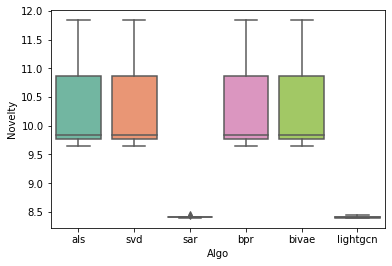

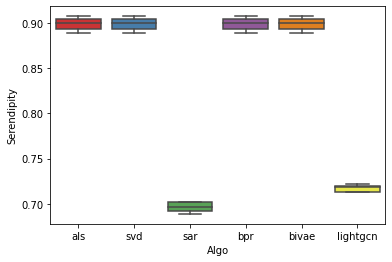

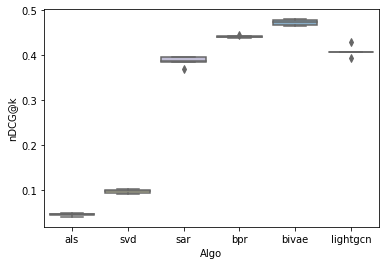

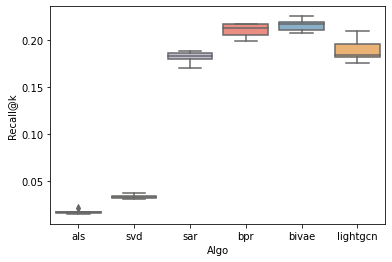

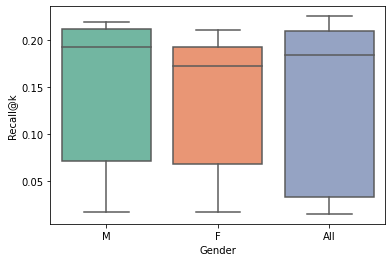

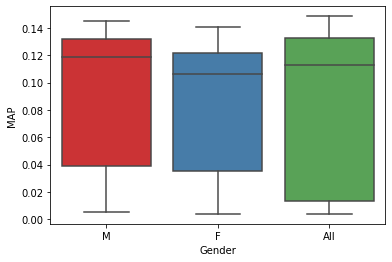

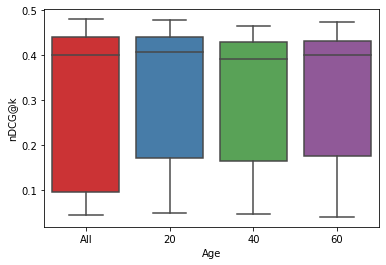

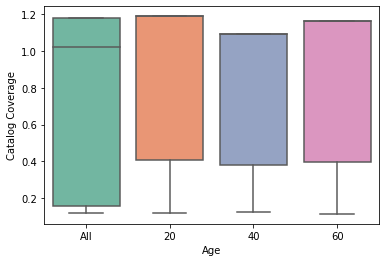

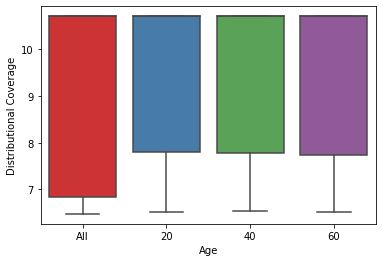

In [50]:
output = pd.read_csv('benchmark_per_category.csv',index_col =0 )
# print(output.columns)
print(output.columns)

g = sns.boxplot(x="Algo", y="Novelty",data=output, palette="Set2");
plt.savefig('Outputs/benchmark_novelty.png')
plt.figure()
g = sns.boxplot(x="Algo", y="Serendipity",data=output, palette="Set1");
plt.savefig('Outputs/benchmark_serendipity.png')

plt.figure()
g = sns.boxplot(x="Algo", y="nDCG@k",data=output, palette="Set3");
plt.figure()
g = sns.boxplot(x="Algo", y="Recall@k",data=output, palette="Set3");
plt.figure()
g = sns.boxplot(x="Gender", y="Recall@k",data=output, palette="Set2");
plt.savefig('Outputs/women_vs_men_recall.png')
plt.figure()
g = sns.boxplot(x="Gender", y="MAP",data=output, palette="Set1");
plt.savefig('Outputs/women_vs_men_precision.png')
plt.figure()
g = sns.boxplot(x="Age", y="nDCG@k",data=output, palette="Set1");
plt.figure()
g = sns.boxplot(x="Age", y="Catalog Coverage",data=output, palette="Set2");
plt.figure()
g = sns.boxplot(x="Age", y="Distributional Coverage",data=output, palette="Set1")
# sns.boxplot(data=output[output['Algo']=='als'], orient="h", palette="Set2")
# sns.boxplot(data=output[output['Algo']=='bivae'], orient="h", palette="Set1")
output.sort_values(by = ['Novelty'])

## Train on synthetic data

### Neural Collaborative Filtering

In [82]:
%%time
EPOCHS = 50
BATCH_SIZE = 256
synthetic_df = restricted_df 
train, test = python_stratified_split(synthetic_df, 0.75)
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]
train_file = "./train.csv"
test_file = "./test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:recommenders.models.ncf.dataset:Indexing ./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./test_full.csv ...
/Users/loqmansalamatian/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/DeepLearningCOMS4995/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [6.75s]: train_loss = 0.255987 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [10.69s]: train_loss = 0.251417 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [2.62s]: train_loss = 0.242874 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [3.00s]: train_loss = 0.238795 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [2.48s]: train_loss = 0.229787 


Took 212.0031 seconds for training.
CPU times: user 2min 53s, sys: 13.8 s, total: 3min 7s
Wall time: 5min 2s


In [83]:
# pd.merge(
#     test,
#     users_df,
#     on='userID'
#  )
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
#     all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))
merged


Took 1.8345 seconds for prediction.


,itemID,userID,rating,group,category,age,prediction
0,244,0,0.5,2.0,0.0,45.0,0.963886
1,169,0,1.5,1.0,0.0,45.0,0.091304
2,317,0,2.5,3.0,0.0,25.0,0.843895
3,259,0,3.0,2.0,0.0,30.0,0.699574
4,315,0,2.5,3.0,0.0,45.0,0.903123
...,...,...,...,...,...,...,...
64495,281,249,NaN,NaN,NaN,NaN,0.008730
64496,176,249,NaN,NaN,NaN,NaN,0.016333
64497,282,249,NaN,NaN,NaN,NaN,0.018189
64498,4,249,NaN,NaN,NaN,NaN,0.022042


In [90]:
top_k_predictions = [] 
TOP_K = 10
for identified,all_predictions_user_k in all_predictions.groupby('itemID'):
    top_k_predictions.append(all_predictions_user_k.sort_values(by = 'prediction',ascending= False)[:TOP_K])
top_k_predictions = pd.concat(top_k_predictions)

top_k_groundtruth = [] 
for identified,all_predictions_user_k in df_with_poisson.groupby('itemID'):
    top_k_groundtruth.append(all_predictions_user_k.sort_values(by = 'rating',ascending= False)[:TOP_K])
print(identified)
top_k_groundtruth = pd.concat(top_k_groundtruth)

eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')
from recommenders.evaluation.python_evaluation import catalog_coverage, novelty, distributional_coverage, diversity, serendipity


# catalog_coverage_output = catalog_coverage(
# train, top_k_predictions, col_user='userID', col_item='itemID'
# )
# print('Catalag Coverage computed : ', catalog_coverage_output )
# # serendipity_output = serendipity(train, top_k_predictions)
# # print('Serendipity computed : ', serendipity_output )
# distributional_coverage_output = distributional_coverage(train,top_k_predictions)
# print('Distributional Coverage computed : ', distributional_coverage_output )
# novelty_output = novelty(train, top_k_predictions)
# print('Novelty computed : ',novelty_output) 
# diversity_output = diversity(train,top_k_predictions)
# top_k_predictions['color'] = 'blue'
# top_k


import networkx as nx
#Create the expected graph
G_all = nx.Graph()

top_k_groundtruth = [] 
df_with_poisson = df_with_poisson[df_with_poisson['itemID'].isin(merged['itemID'])]
df_with_poisson = df_with_poisson[df_with_poisson['userID'].isin(merged['userID'])]
for identified,all_predictions_user_k in df_with_poisson.groupby('userID'):
    top_k_groundtruth.append(all_predictions_user_k.sort_values(by = 'rating',ascending= False)[:TOP_K])
top_k_groundtruth = pd.concat(top_k_groundtruth)
top_k_groundtruth.shape[0]

#Add nodes
edges = []
for (uId, mId, rating) in top_k_groundtruth[['userID', 'itemID', 'rating']].to_numpy():
    edges.append(('u'+ str(int(uId)),'i' + str(int(mId)), rating))
# G.add_nodes_from(nodesA, bipartite=0)
# G.add_nodes_from(nodesB, bipartite=1)
# print(len(G.nodes()))
G_all.add_weighted_edges_from(edges)
################################################################################################################
top_k_predictions = [] 
for identified,all_predictions_user_k in merged.groupby('userID'):
    top_k_predictions.append(all_predictions_user_k.sort_values(by = 'prediction',ascending= False)[:TOP_K])
top_k_predictions = pd.concat(top_k_predictions)
G_predicted = nx.Graph()
edges = []
for (uId, mId, rating) in top_k_predictions[['userID', 'itemID', 'prediction']].to_numpy():
    edges.append(('u'+ str(int(uId)),'i' + str(int(mId)), rating))
# G_all.add_nodes_from(nodesA,bipartite =0)
# G_all.add_nodes_from(nodesB, bipartite = 1)
G_predicted.add_weighted_edges_from(edges)
################################################################################################################

nx.info(G_predicted),nx.info(G_all)

399
MAP:	0.137929
NDCG:	0.279027
Precision@K:	0.208000
Recall@K:	0.404851


/var/folders/x6/hdt99h_x0kd8n0pyzdgks3hw0000gn/T/ipykernel_41274/3633097530.py:74: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_predicted),nx.info(G_all)


('Graph with 270 nodes and 2500 edges', 'Graph with 508 nodes and 2500 edges')

In [91]:
nx.set_node_attributes(G_all,dict_user,'group')
nx.set_node_attributes(G_all,dict_items,'category')
nx.set_node_attributes(G_predicted, dict_user, 'group')
nx.set_node_attributes(G_predicted, dict_items, 'category')
nx.write_graphml(G_all,'Outputs/graph_ground_truth.graphml')
nx.write_graphml(G_predicted,'Outputs/graph_predicted.graphml')

#### Conclusion
The comparision results show that the ALS recommender outperforms the random recommender on ranking metrics (Precision@k, Recall@k, NDCG@k, and	Mean average precision), while the random recommender outperforms ALS recommender on diversity metrics. This is because ALS is optimized for estimating the item rating as accurate as possible, therefore it performs well on accuracy metrics including rating and ranking metrics. As a side effect, the items being recommended tend to be popular items, which are the items mostly sold or viewed. It leaves the long-tail less popular items having less chance to get introduced to the users. This is the reason why ALS is not performing as well as a random recommender on diversity metrics. 

In [ ]:
# cleanup spark instance
spark.stop()